<a href="https://colab.research.google.com/github/RobyRoshna/Insensitive-Lang-Detection/blob/Training/BERTAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and custom info

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from huggingface_hub import login
import wandb
from transformers import Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification, set_seed
import pandas as pd
import random
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report, confusion_matrix
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.4 MB/s eta 0:00:00


In [ ]:
#Note: random_state for splits need to set separately for this study its 42 throughout
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
set_seed(42)

In [ ]:
# Custom Dataset Class for Tokenized Data
class SentenceDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        """
        Initializes the dataset.

        Args:
            encodings: Dictionary containing tokenized input IDs, attention masks, etc.
            labels: List of labels corresponding to the sentences (e.g., 0 for NotInsensitive, 1 for Insensitive).
        """
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieves the tokenized inputs and the corresponding label for the given index.

        Args:
            idx: Index of the data sample.

        Returns:
            A dictionary containing the tokenized inputs (input IDs, attention masks, etc.)
            and the label for the specified index.
        """
        # Convert tokenized data for the index to PyTorch tensors
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Ensure the label key is 'labels'
        item['labels'] = torch.tensor(self.labels[idx])  # Add the corresponding label
        return item

# Function to compute metrics
def compute_metrics(pred):
    predictions, labels = pred
    preds = predictions.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# EXP 2: Test original test set on augmented model


Loaded Model Path: /content/drive/MyDrive/Honours MiscData(Roshna)/Aug_bert_base_modelV3



Test Set Evaluation
Accuracy: 0.9358
Precision: 0.9354
Recall: 0.9327
F1 Score: 0.9340

Confusion Matrix - Test Set:
                       Predicted NotInsensitive  Predicted Insensitive
Actual NotInsensitive                        60                      3
Actual Insensitive                            4                     42

False Positives:
                                             Sentence  Manual_Annotation
19  We started working with the patient when he wa...                  0
31  However, language immersion can be particularl...                  0
46  Gaze typing for people with extreme motor disa...                  0

False Negatives:
                                              Sentence  Manual_Annotation
6    Our research contributes empirical evidence de...                  1
89   In this paper, we describe why designers need ...                  1
101  In our system, besides the user’s speech, the ...                  1
106  Children with autism spectrum disorder a

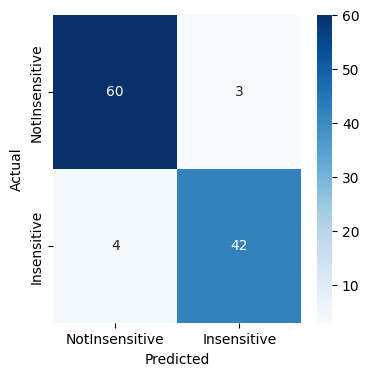

test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
test_accuracy,0.93578
test_f1,0.93398
test_precision,0.93542
test_recall,0.93271


In [ ]:
import pandas as pd
import torch
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

test_dataexp = pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/test_dataOriginal.csv")

# Load the saved model
model_path = "/content/drive/MyDrive/Honours MiscData(Roshna)/Aug_bert_base_modelV3"
modelAug = BertForSequenceClassification.from_pretrained(model_path)
modelAug.eval()

print("\nLoaded Model Path:", model_path)

wandb.finish()
wandb.init(project="Insensitive Lang Detection", entity="Roshna", name="Bert_baseOripred")

tokenizer = BertTokenizer.from_pretrained(model_path)
inputs = tokenizer(list(test_dataexp['Sentence']), padding=True, truncation=True, return_tensors="pt")


with torch.no_grad():
    outputs = modelAug(**inputs)
    confidences = torch.softmax(outputs.logits, dim=1)

test_predictions = outputs.logits.argmax(dim=1).cpu().numpy()
test_true_labels = test_dataexp['Manual_Annotation'].values


accuracy = accuracy_score(test_true_labels, test_predictions)
class_report = classification_report(test_true_labels, test_predictions, output_dict=True)
conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# Extract Precision, Recall, and F1-score - macro average gives equal importance to both classes in binary classification
precision = class_report["macro avg"]["precision"]
recall = class_report["macro avg"]["recall"]
f1 = class_report["macro avg"]["f1-score"]

wandb.log({
    "test_accuracy": accuracy,
    "test_precision": precision,
    "test_recall": recall,
    "test_f1": f1
})


print("\nTest Set Evaluation")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix_df = pd.DataFrame(conf_matrix,
                              columns=["Predicted NotInsensitive", "Predicted Insensitive"],
                              index=["Actual NotInsensitive", "Actual Insensitive"])

print("\nConfusion Matrix - Test Set:")
print(conf_matrix_df)

wandb.log({"confusion_matrix": wandb.Table(dataframe=conf_matrix_df)})

# Analyze false positives & false negatives
false_positives = test_dataexp[(test_true_labels == 0) & (test_predictions == 1)].copy()
false_negatives = test_dataexp[(test_true_labels == 1) & (test_predictions == 0)].copy()

print("\nFalse Positives:")
print(false_positives[['Sentence', 'Manual_Annotation']])

print("\nFalse Negatives:")
print(false_negatives[['Sentence', 'Manual_Annotation']])

# Confidence scores
test_dataexp['Confidence_Positive'] = confidences[:, 1].cpu().numpy()
test_dataexp['Confidence_Negative'] = confidences[:, 0].cpu().numpy()

# Assign confidence values to misclassified examples
false_positives['Confidence_Positive'] = test_dataexp.loc[false_positives.index, 'Confidence_Positive'].values
false_negatives['Confidence_Negative'] = test_dataexp.loc[false_negatives.index, 'Confidence_Negative'].values

print("\nFalse Positives with Confidence:")
print(false_positives[['Sentence', 'Manual_Annotation', 'Confidence_Positive']])

print("\nFalse Negatives with Confidence:")
print(false_negatives[['Sentence', 'Manual_Annotation', 'Confidence_Negative']])

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NotInsensitive", "Insensitive"],
            yticklabels=["NotInsensitive", "Insensitive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("OriginalTestset.png")
plt.show()

# Finish WandB logging
wandb.finish()


# Dataset Prep

In [ ]:

# The augmentated dataset
file_path = '/content/drive/MyDrive/Honours MiscData(Roshna)/25Augmented_annotationsV3.xlsx'
data = pd.read_excel(file_path)

# cleaning data
data = data[['Sentence', 'Label','Term']]
data = data.dropna()

# 1 for insensitive and 0 for notInsensitive
data['Label'] = data['Label']

# Split the data into train, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.2, stratify=data['Label'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['Label'],random_state=42)

print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")
# Save train, val, and test splits
train_data.to_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/AugTrain_dataV2.csv", index=False)
val_data.to_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/AugVal_dataV2.csv", index=False)
test_data.to_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/AugTest_dataV2.csv", index=False)

Train size: 1720, Validation size: 215, Test size: 215


In [ ]:

print(data['Label'].value_counts(normalize=True))

# Check class proportions in train, val, and test sets
print(train_data['Label'].value_counts(normalize=True))
print(val_data['Label'].value_counts(normalize=True))
print(test_data['Label'].value_counts(normalize=True))


Label
1    0.5
0    0.5
Name: proportion, dtype: float64
Label
1    0.5
0    0.5
Name: proportion, dtype: float64
Label
1    0.502326
0    0.497674
Name: proportion, dtype: float64
Label
0    0.502326
1    0.497674
Name: proportion, dtype: float64


In [ ]:
train_dataAug=pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/AugTrain_dataV2.csv")
val_dataAug=pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/AugVal_dataV2.csv")
test_dataAug=pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/AugTest_dataV2.csv")
print(f"Duplicates in train data: {train_data.duplicated(subset=['Sentence', 'Label']).sum()}")
print(f"Duplicates in validation data: {val_data.duplicated(subset=['Sentence', 'Label']).sum()}")
print(f"Duplicates in test data: {test_data.duplicated(subset=['Sentence', 'Label']).sum()}")

Duplicates in train data: 0
Duplicates in validation data: 0
Duplicates in test data: 0


In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize data
def tokenize_data(data, tokenizer, max_length=109):
    return tokenizer(
        list(data['Sentence']),  # Tokenize sentences
        padding=True,            # Pad shorter sentences
        truncation=True,         # Truncate longer sentences
        max_length=max_length,   # Max token length
        return_tensors='pt'      # Return PyTorch tensors
    )

train_labels = list(train_dataAug['Label'])
val_labels = list(val_dataAug['Label'])
test_labels = list(test_dataAug['Label'])

# Tokenize the data
train_encodingsAug = tokenize_data(train_dataAug, tokenizer)
val_encodingsAug = tokenize_data(val_dataAug, tokenizer)
test_encodingsAug = tokenize_data(test_dataAug, tokenizer)


# Save tokenized data
np.save("/content/drive/MyDrive/Honours MiscData(Roshna)/Augtrain_encodings_input_ids.npy", train_encodingsAug['input_ids'].numpy())
np.save("/content/drive/MyDrive/Honours MiscData(Roshna)/Augtrain_encodings_attention_mask.npy", train_encodingsAug['attention_mask'].numpy())
np.save("/content/drive/MyDrive/Honours MiscData(Roshna)/Augtrain_labels.npy", np.array(train_labels))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:

# Create datasets for train, validation, and test sets
train_datasetAug = SentenceDataset(train_encodingsAug, train_labels)
val_datasetAug = SentenceDataset(val_encodingsAug, val_labels)
test_datasetAug = SentenceDataset(test_encodingsAug, test_labels)


# Save the train, val, and test datasets
with open("/content/drive/MyDrive/Honours MiscData(Roshna)/Augtrain_datasetV2.pkl", "wb") as f:
    pickle.dump(train_datasetAug, f)
with open("/content/drive/MyDrive/Honours MiscData(Roshna)/Augval_datasetV2.pkl", "wb") as f:
    pickle.dump(val_datasetAug, f)
with open("/content/drive/MyDrive/Honours MiscData(Roshna)/Augtest_datasetV2.pkl", "wb") as f:
    pickle.dump(test_datasetAug, f)


# Final BERT Model

In [ ]:
# Load pre-trained BERT for binary classification
modelBbaseAugV3 = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Safe close any previous WandB session
wandb.finish()

# Initialize WandB with a specific run name
wandb.init(project="Insensitive Lang Detecton", entity="Roshna", name="Bert_baseAugV3")

# TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=10,
    report_to=["wandb"],  # WandB is used for logging
    run_name="Bert_baseAugV3"  # the run name for this Trainer
)

# Trainer
trainer = Trainer(
    model=modelBbaseAugV3,
    args=training_args,
    train_dataset=train_datasetAug,
    eval_dataset=val_datasetAug,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

# Compute training metrics at the end of training
train_results = trainer.predict(train_datasetAug)  # Get predictions on the training dataset

# Extract predictions and labels
predictions = train_results.predictions
labels = train_results.label_ids

# Compute metrics using the compute_metrics function
train_metrics = compute_metrics((predictions, labels))  # Pass predictions and labels as a tuple

# Log training metrics
wandb.log({f"train_{key}": value for key, value in train_metrics.items()})

# Output the metrics at the end of training
print("Training Metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")


# Compute evaluation metrics on the test set
test_results = trainer.evaluate(test_datasetAug, metric_key_prefix="test")
wandb.log(test_results)
wandb.finish()

wandb: Currently logged in as: roshnaroby (Roshna) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<ipython-input-3-1302a6248933>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.198500,0.242338,0.920930,0.902655,0.944444,0.923077
2,0.132500,0.199278,0.948837,0.961905,0.935185,0.948357
3,0.013100,0.141965,0.967442,0.980952,0.953704,0.967136


<ipython-input-3-1302a6248933>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-3-1302a6248933>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-3-1302a6248933>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-3-1302a6248933>:32: UserWarning: To copy construct from a 

Training Metrics:
accuracy: 0.9959
precision: 0.9954
recall: 0.9965
f1: 0.9959


<ipython-input-3-1302a6248933>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


epoch,▁
eval/accuracy,▁▅█
eval/f1,▁▅█
eval/loss,█▅▁
eval/precision,▁▆█
eval/recall,▄▁█
eval/runtime,▁▇█
eval/samples_per_second,█▂▁
eval/steps_per_second,█▂▁
test/accuracy,█▁
test/f1,█▁


In [ ]:
# Save the trained model and tokenizer
save_directory = "/content/drive/MyDrive/Honours MiscData(Roshna)/Aug_bert_base_modelV3"
trainer.save_model(save_directory)  # Save model
tokenizer.save_pretrained(save_directory)  # Save tokenizer

('/content/drive/MyDrive/Honours MiscData(Roshna)/Aug_bert_base_modelV3/tokenizer_config.json',
 '/content/drive/MyDrive/Honours MiscData(Roshna)/Aug_bert_base_modelV3/special_tokens_map.json',
 '/content/drive/MyDrive/Honours MiscData(Roshna)/Aug_bert_base_modelV3/vocab.txt',
 '/content/drive/MyDrive/Honours MiscData(Roshna)/Aug_bert_base_modelV3/added_tokens.json')

In [ ]:
wandb.finish()
wandb.init(project="Insensitive Lang Detecton", entity="Roshna", name="Bert_baseAugpred")
# Get predictions on the test data
test_results = trainer.predict(test_datasetAug)

# Extract predictions and true labels
test_predictions = test_results.predictions.argmax(axis=1)  # Get predicted classes
test_true_labels = test_results.label_ids
wandb.finish()

<ipython-input-3-1302a6248933>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


test/accuracy,▁
test/f1,▁
test/loss,▁
test/precision,▁
test/recall,▁
test/runtime,▁
test/samples_per_second,▁
test/steps_per_second,▁
test/accuracy,0.96279
test/f1,0.96262
test/loss,0.15814


## Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# Convert confusion matrix to a DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix,
                              columns=["Predicted NotInsensitive", "Predicted Insensitive"],
                              index=["Actual NotInsensitive", "Actual Insensitive"])

print("Confusion Matrix - Test Set:")
print(conf_matrix_df)

# Analyze false positives and false negatives
false_positives = test_data[(test_true_labels == 0) & (test_predictions == 1)].copy()
false_negatives = test_data[(test_true_labels == 1) & (test_predictions == 0)].copy()

print("False Positives:")
print(false_positives[['Sentence', 'Term']])

print("\nFalse Negatives:")
print(false_negatives[['Sentence', 'Term']])

# Load the trained model for confidence scores
model_path = "/content/drive/MyDrive/Honours MiscData(Roshna)/Aug_bert_base_modelV2.3"
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Tokenize test sentences
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)
inputs = tokenizer(list(test_data['Sentence']), padding=True, truncation=True, return_tensors="pt")

# Get model outputs
with torch.no_grad():
    outputs = model(**inputs)
    confidences = torch.softmax(outputs.logits, dim=1)  # Get probabilities

# Add confidence scores to the dataset
test_data = test_data.copy()  # Ensure modifications don't trigger a warning
test_data['Confidence_Positive'] = confidences[:, 1].cpu().numpy()
test_data['Confidence_Negative'] = confidences[:, 0].cpu().numpy()

# Assign confidence values to misclassified examples
false_positives['Confidence_Positive'] = test_data.loc[false_positives.index, 'Confidence_Positive'].values
false_negatives['Confidence_Negative'] = test_data.loc[false_negatives.index, 'Confidence_Negative'].values

print("False Positives with Confidence:")
print(false_positives[['Sentence', 'Term', 'Confidence_Positive']])

print("\nFalse Negatives with Confidence:")
print(false_negatives[['Sentence', 'Term', 'Confidence_Negative']])


Confusion Matrix - Test Set:
                       Predicted NotInsensitive  Predicted Insensitive
Actual NotInsensitive                       104                      4
Actual Insensitive                            4                    103
False Positives:
                                               Sentence  \
826   Promising new research appears to suggest the ...   
1690  "The product was designed to support a deaf pe...   
843   "Language development tools can benefit childr...   
784   "The interface was designed to prioritize the ...   

                           Term  
826                    disorder  
1690                deaf person  
843                    disorder  
784   persons with disabilities  

False Negatives:
                                               Sentence           Term
819   "The study highlights the dependence of indivi...       disorder
450   According to psychological model of spatial na...         mental
1750  While almost all AAC users have speech

# Logistic Regression on Augmented data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Load datasets
train_df = pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/AugTrain_dataV2.csv")
val_df = pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/AugVal_dataV2.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Honours MiscData(Roshna)/AugTest_dataV2.csv")

X_train, y_train = train_df['Sentence'], train_df['Label']
X_val, y_val = val_df['Sentence'], val_df['Label']
X_test, y_test = test_df['Sentence'], test_df['Label']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression Model
logistic_reg_model = LogisticRegression(max_iter=500, C=1.0)
logistic_reg_model.fit(X_train_tfidf, y_train)

# Function to Evaluate Model & Print Correct Metrics
def evaluate_model(model, X, y, dataset_name, dataset_df=None, show_conf_matrix=False):
    """Evaluates the model and prints precision, recall, F1-score, and accuracy."""

    predictions = model.predict(X)

    # Compute metrics manually
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)

    # Print results
    print(f"\n{dataset_name} Set Evaluation")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")  # Now recall should be distinct
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix & Misclassified Examples (Only for test set)
    if show_conf_matrix and dataset_df is not None:
        conf_matrix = confusion_matrix(y, predictions)
        print("\nConfusion Matrix - Test Set:")
        print(pd.DataFrame(conf_matrix,
                           columns=["Predicted NotInsensitive", "Predicted Insensitive"],
                           index=["Actual NotInsensitive", "Actual Insensitive"]))

        # Get misclassified examples
        misclassified_df = dataset_df[y != predictions]

        print("\nMisclassified Examples:")
        print(misclassified_df[['Sentence', 'Label']])

# Evaluate Train, Validation, and Test Sets
evaluate_model(logistic_reg_model, X_train_tfidf, y_train, "Train")
evaluate_model(logistic_reg_model, X_val_tfidf, y_val, "Validation")
evaluate_model(logistic_reg_model, X_test_tfidf, y_test, "Test", dataset_df=test_df, show_conf_matrix=True)



Train Set Evaluation
Accuracy: 0.9564
Precision: 0.9746
Recall: 0.9372
F1 Score: 0.9555

Validation Set Evaluation
Accuracy: 0.8791
Precision: 0.8796
Recall: 0.8796
F1 Score: 0.8796

Test Set Evaluation
Accuracy: 0.8930
Precision: 0.9118
Recall: 0.8692
F1 Score: 0.8900

Confusion Matrix - Test Set:
                       Predicted NotInsensitive  Predicted Insensitive
Actual NotInsensitive                        99                      9
Actual Insensitive                           14                     93

Misclassified Examples:
                                              Sentence  Label
2    Preliminary results of 5 healthy college stude...      1
17   However, to the best of our knowledge, there i...      1
24   "The product was designed to support a deaf pe...      0
30   "Language development tools can benefit childr...      0
34   This proves that it is possible to design incl...      1
64   According to psychological model of spatial na...      1
77   In this poster we prop

In [ ]:
import joblib
model_filename = "/content/drive/MyDrive/Honours MiscData(Roshna)/Auglogistic_regression_model.pkl"
vectorizer_filename = "/content/drive/MyDrive/Honours MiscData(Roshna)/Augtfidf_vectorizer.pkl"

joblib.dump(logistic_reg_model, model_filename)
joblib.dump(vectorizer, vectorizer_filename)

['/content/drive/MyDrive/Honours MiscData(Roshna)/Augtfidf_vectorizer.pkl']

In [ ]:
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# File Paths
model_filename = "/content/drive/MyDrive/Honours MiscData(Roshna)/Auglogistic_regression_model.pkl"
vectorizer_filename = "/content/drive/MyDrive/Honours MiscData(Roshna)/Augtfidf_vectorizer.pkl"
new_test_data_path = "/content/drive/MyDrive/Honours MiscData(Roshna)/test_dataOriginal.csv"

# Load Saved Model & Vectorizer
logistic_reg_model = joblib.load(model_filename)
vectorizer = joblib.load(vectorizer_filename)

# Load New Test Dataset
new_test_df = pd.read_csv(new_test_data_path)

# Extract Sentences and Labels
X_new_test, y_new_test = new_test_df['Sentence'], new_test_df['Manual_Annotation']

# Transform Using the Same TF-IDF Vectorizer
X_new_test_tfidf = vectorizer.transform(X_new_test)

# Function to Evaluate Model & Print Correct Metrics
def evaluate_model(model, X, y, dataset_name, dataset_df=None, show_conf_matrix=False):
    """Evaluates the model and prints precision, recall, F1-score, and accuracy."""

    predictions = model.predict(X)

    # Compute Metrics
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)

    # Print Results
    print(f"\n{dataset_name} Set Evaluation")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix & Misclassified Examples
    if show_conf_matrix and dataset_df is not None:
        conf_matrix = confusion_matrix(y, predictions)
        print("\nConfusion Matrix:")
        print(pd.DataFrame(conf_matrix,
                           columns=["Predicted NotInsensitive", "Predicted Insensitive"],
                           index=["Actual NotInsensitive", "Actual Insensitive"]))

        # Get Misclassified Examples
        misclassified_df = dataset_df[y != predictions]

        print("\nMisclassified Examples:")
        print(misclassified_df[['Sentence', 'Manual_Annotation']])

# Evaluate the New Test Set
evaluate_model(logistic_reg_model, X_new_test_tfidf, y_new_test, "New Test", dataset_df=new_test_df, show_conf_matrix=True)



New Test Set Evaluation
Accuracy: 0.7064
Precision: 0.9375
Recall: 0.3261
F1 Score: 0.4839

Confusion Matrix:
                       Predicted NotInsensitive  Predicted Insensitive
Actual NotInsensitive                        62                      1
Actual Insensitive                           31                     15

Misclassified Examples:
                                              Sentence  Manual_Annotation
6    Our research contributes empirical evidence de...                  1
7    In previous work we have presented a prototype...                  1
8    In this paper, we present the results from pil...                  1
11   Story Blocks provides an introductory programm...                  1
14   This paper introduces our research project for...                  1
15   In this paper, we report on the experiences of...                  1
16   Even after decades of research about navigatio...                  1
22   To address this issue, our team used Visual St...     

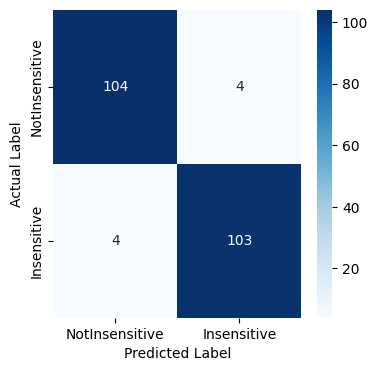

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the confusion matrix
conf_matrix = np.array([[104, 4],
                        [4, 103]])

# Define class labels
labels = ["Not Insensitive", "Insensitive"]

# Create the heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["NotInsensitive", "Insensitive"], yticklabels=["NotInsensitive", "Insensitive"])

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.savefig("Augmatrix.png")
# Show the plot
plt.show()
